## Load Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import categorical_accuracy #AUC 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GINConv,GCNConv #, GCSConv, GlobalAvgPool
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.data import DisjointLoader, BatchLoader, Dataset, Graph
from spektral.transforms.normalize_adj import NormalizeAdj
from spektral.transforms.normalize_one import NormalizeOne
from spektral.transforms.normalize_sphere import NormalizeSphere
import gc
import spektral.datasets
from spektral.data import DisjointLoader, BatchLoader
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from spektral.models.gcn import GCN 
import glob

2023-05-05 14:20:46.655995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create Dataset Class

In [2]:
import os
import pandas as pd
import numpy as np
from scipy import sparse
import gc
from spektral.data import Dataset, Graph

# Custom dataset class
class MyDataset(Dataset):

    def __init__(self, graph_feature_files, ncol_files, **kwargs):
        # Store the graph feature and ncol file lists
        self.graph_feature_files = graph_feature_files
        self.ncol_files = ncol_files
        super().__init__(**kwargs)

    def download(self):
        pass

    def read(self):
        # We must return a list of Graph objects
        output = []

        # Iterate through graph_feature_files and ncol_files
        for graph_feature_file, ncol_file in zip(self.graph_feature_files, self.ncol_files):
            # Read graph features
            x_tmp = pd.read_csv(graph_feature_file, sep=",", header=0)
            # Replace background for normal
            x_tmp['label'] = x_tmp['label'].replace('background','normal')
            # Read graph topology
            a_tmp = pd.read_csv(ncol_file, sep=" ", header=None, names=["source", "target", "weight"])

            # Create dictionaries that identify each node and label with an integer
            class_idx = {name: idx for idx, name in enumerate(sorted(x_tmp["label"].unique()))}
            node_idx = {name: idx for idx, name in enumerate(sorted(x_tmp["node"].unique()))}

            # Change node names and label for their corresponding integer
            x_tmp["node"] = x_tmp["node"].apply(lambda name: node_idx[name])
            x_tmp["label"] = x_tmp["label"].apply(lambda value: class_idx[value])
            a_tmp["source"] = a_tmp["source"].apply(lambda name: node_idx[name])
            a_tmp["target"] = a_tmp["target"].apply(lambda name: node_idx[name])

            # Node features:
            x = x_tmp.sort_values("node")[x_tmp.columns.difference(["node","label"], sort=False)].to_numpy()
            x = x.astype(np.float32)

            # Create adjacency matrix from source, target, and weight
            a_source = a_tmp[["source"]].to_numpy().T
            a_source = np.reshape(a_source, a_source.shape[-1])
            a_target = a_tmp[["target"]].to_numpy().T
            a_target = np.reshape(a_target, a_target.shape[-1])
            a_weight = a_tmp[["weight"]].to_numpy().T
            a_weight = np.reshape(a_weight, a_weight.shape[-1])

            # Adjacency matrix:
            #a = sparse.coo_matrix((a_weight, (a_source, a_target)), shape=(x.shape[0], x.shape[0]))
            a = sparse.csr_matrix((a_weight, (a_source, a_target)), shape=(x.shape[0], x.shape[0]), dtype=np.float32)

              # Label (CTU13random):
            #y = []
            #for j in range(x_tmp.shape[0]):
            #     np.random.seed(200+j)
            #     y_tmp = np.random.randint(0,2)
            #     if y_tmp:
            #         y.append(np.array([1., 0.]))
            #     else:
            #         y.append(np.array([0., 1.]))
            #y = np.array(y)
            #y_one_hot = y.astype(np.int64)

            # Label:
            y = x_tmp.sort_values("node")["label"].to_numpy()
            y.astype(np.int64)
            y_one_hot = np.eye(2)[y]
            
            # Create a Graph object and add it to the output list
            output.append(Graph(x=x, a=a, y=y_one_hot))

            # Free memory
            del x_tmp, x, a_tmp, a_source, a_target, a_weight, a, y
            gc.collect()

        return output



## Instance CTU13 Dataset

In [3]:
# Create a list of graph feature files and ncol files
graph_feature_files = sorted(glob.glob("/mnt/CEPH/ctu13/features/*"))
ncol_files = sorted(glob.glob("/mnt/CEPH/ctu13/ncol/*"))

ncol_files
# Instantiate the dataset
dataset = MyDataset(graph_feature_files, ncol_files,transforms=[NormalizeAdj(symmetric=False)])

In [4]:
dataset[0]

Graph(n_nodes=605195, n_node_features=7, n_edge_features=None, n_labels=2)

In [5]:
for j in range(13):
    suma = 0
    for i in range(dataset[j].n_nodes):
        if all(dataset[j].y[i] == [0.,1.]):
            suma+=1
    print("cap ",j+1,": infected:",suma, " - normal:",dataset[j].n_nodes-suma, " -- prop:",suma/dataset[j].n_nodes)

cap  1 : infected: 605194  - normal: 1  -- prop: 0.9999983476400168
cap  2 : infected: 440573  - normal: 1  -- prop: 0.9999977302337405
cap  3 : infected: 430264  - normal: 1  -- prop: 0.999997675850929
cap  4 : infected: 41398  - normal: 1  -- prop: 0.9999758448271697
cap  5 : infected: 313677  - normal: 1  -- prop: 0.9999968120174192
cap  6 : infected: 184900  - normal: 1  -- prop: 0.9999945917004235
cap  7 : infected: 37942  - normal: 1  -- prop: 0.9999736446775427
cap  8 : infected: 381449  - normal: 1  -- prop: 0.999997378424433
cap  9 : infected: 106579  - normal: 1  -- prop: 0.9999906173766185
cap  10 : infected: 365784  - normal: 10  -- prop: 0.9999726622087842
cap  11 : infected: 41709  - normal: 3  -- prop: 0.999928078250863
cap  12 : infected: 196676  - normal: 10  -- prop: 0.9999491575404452
cap  13 : infected: 93827  - normal: 3  -- prop: 0.9999680272833849


## Split train/test

In [6]:
dataset_test2 = dataset[9]
dataset = dataset[:8] + dataset[9:]


split = int(0.8 * len(dataset))
dataset_train, dataset_test = dataset[:split], dataset[split:]

In [27]:
dataset_train
dataset_test[0].n_nodes

41712

In [8]:
batch_size = 1
loader_train = DisjointLoader(dataset_train, node_level= True,     batch_size=batch_size, epochs=800, shuffle=False, )
loader_test = DisjointLoader(dataset_test, node_level = True, batch_size=batch_size)

## Create a custom GCN model (not used)

In [9]:
def create_gcn_model():
    # Define input placeholders for node features, adjacency matrix, and segment indices
    X_in = Input(shape=(dataset.n_node_features,))
    A_in = Input((None,), sparse=True)
    I_in = Input(shape=(), dtype=tf.int32)

    # Apply the first GINConv layer with 32 units and ReLU activation
    X_1 = GINConv(32, activation="relu")([X_in, A_in])
    # Apply dropout with a rate of 0.5
    X_1 = Dropout(0.5)(X_1)

    # Apply the second GINConv layer with 32 units and ReLU activation
    X_2 = GINConv(32, activation="relu")([X_1, A_in])
    # Apply dropout with a rate of 0.5
    X_2 = Dropout(0.5)(X_2)

    # Aggregate the node features using the segment_mean function and the segment indices
    X_3 = tf.math.segment_mean(X_2, I_in)
    # Apply a dense output layer with the number of labels and softmax activation
    out = Dense(dataset.n_labels, activation="softmax")(X_3)

    # Create and return the model with the defined inputs and outputs
    model = Model(inputs=[X_in, A_in, I_in], outputs=out)
    return model

## Load standard GCN model

In [10]:
#model = create_gcn_model()
model = GCN(n_labels=dataset.n_labels)
optimizer = Adam(lr=0.01)
loss_fn = BinaryCrossentropy()
auc_metric = AUC()

2023-05-05 14:21:20.951103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-05 14:21:20.955188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-05 14:21:20.958504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Function for training the model

In [11]:
# Decorate the function with @tf.function to compile as a TensorFlow graph
# Use the input_signature from loader_train and relax shapes for varying graph sizes
@tf.function(input_signature=loader_train.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    #print(inputs.shape)
    # Create a GradientTape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Compute model predictions with the inputs, set training=True for training-specific behaviors
        predictions = model(inputs, training=True)
        # Calculate the loss using the provided loss_fn and add the model's regularization losses
        loss = loss_fn(target, predictions) + sum(model.losses)

    # Compute gradients of the loss with respect to the model's trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply the gradients to the model's variables using the optimizer's apply_gradients method
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Compute the accuracy using the categorical_accuracy function from TensorFlow
    # Calculate the mean accuracy using tf.reduce_mean
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
     # Update the AUC metric
    auc_metric.update_state(target, predictions)
    # Get the current AUC value
    auc = auc_metric.result()


    # Return the loss and accuracy as output
    return loss, acc

### Debug dataset loaders

In [12]:
print("Loader input signature:", loader_train.tf_signature())
sample_batch = loader_train.__next__()
inputs, targets = sample_batch
for tensor in inputs:
    print(tensor.shape, tensor.dtype)
print("Targets shape:", targets.shape, "dtype:", targets.dtype)

Loader input signature: ((TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None]), tf.float32), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))
(605195, 7) float32
(605195, 605195) <dtype: 'float32'>
(605195,) int64
Targets shape: (605195, 2) dtype: float64


## Function to evaluate the performance of the model

In [13]:

def evaluate_auc(loader):
    output = []
    step = 0
    auc_metric_test = AUC()

    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        
        # Update the AUC metric with the true labels and predictions
        auc_metric_test.update_state(target, pred)
        
        outs = (
            loss_fn(target, pred),
            auc_metric_test.result().numpy(),  # Get the current AUC value
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])


In [14]:
def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])

## MAIN CODE for training

In [15]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
results_train = []
# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    inputs,targets = batch
    targets = tf.convert_to_tensor(targets)
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, metric = train_step(inputs,targets)

    # Append the loss and accuracy to the results list
    results.append((loss, metric))
    results_train.append( np.mean(results,0) )
    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_test)

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.3f} - Metric: {:.3f} - Test loss: {:.3f} - Test Metric: {:.3f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []

2023-05-05 14:21:24.593103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int64 and shape [2]
	 [[{{node inputs_3}}]]
2023-05-05 14:21:24.593194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int64 and shape [2]
	 [[{{node inputs_3}}]]
2023-05-05 14:21:24.604673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int64 and shape [2]
	 [[{{node inputs_3}}]]
2023-05-05 14:21

Ep. 0 - Loss: 561079.062 - Metric: 0.335 - Test loss: 214691.183 - Test Metric: 0.067
Ep. 1 - Loss: 276863.906 - Metric: 0.429 - Test loss: 174769.566 - Test Metric: 0.079
Ep. 2 - Loss: 209879.969 - Metric: 0.380 - Test loss: 133365.064 - Test Metric: 0.085
Ep. 3 - Loss: 238868.438 - Metric: 0.370 - Test loss: 90568.914 - Test Metric: 0.089
Ep. 4 - Loss: 158134.547 - Metric: 0.343 - Test loss: 46962.789 - Test Metric: 0.103
Ep. 5 - Loss: 296127.469 - Metric: 0.649 - Test loss: 11806.755 - Test Metric: 0.867
Ep. 6 - Loss: 315598.219 - Metric: 0.505 - Test loss: 72.598 - Test Metric: 0.918
Ep. 7 - Loss: 133288.266 - Metric: 0.256 - Test loss: 121.977 - Test Metric: 0.918
Ep. 8 - Loss: 137229.344 - Metric: 0.593 - Test loss: 164.113 - Test Metric: 0.918
Ep. 9 - Loss: 260022.922 - Metric: 0.700 - Test loss: 213.495 - Test Metric: 0.918
Ep. 10 - Loss: 132599.953 - Metric: 0.821 - Test loss: 262.536 - Test Metric: 0.918
Ep. 11 - Loss: 136943.375 - Metric: 0.805 - Test loss: 301.236 - Test Me

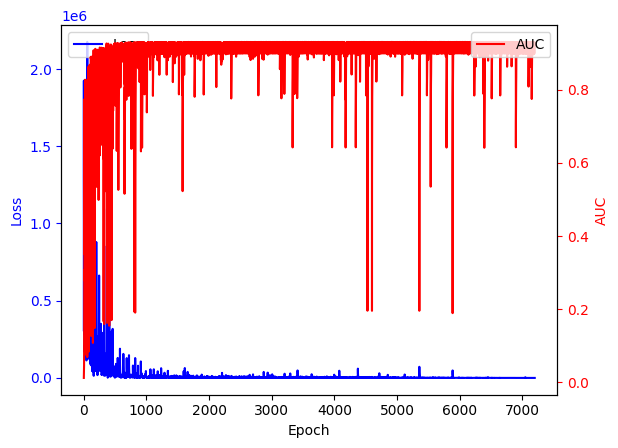

In [16]:
import matplotlib.pyplot as plt
losses_train = [item[0] for item in results_train]
auc_train = [item[1] for item in results_train]

# Create a list of epoch numbers
epochs = list(range(1, len(losses_train) + 1))

# Create a new figure and axis
fig, ax1 = plt.subplots()

# Plot losses_train on the first y-axis
ax1.plot(epochs, losses_train, 'b-', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis to plot auc_train
ax2 = ax1.twinx()
ax2.plot(epochs, auc_train, 'r-', label='AUC')
ax2.set_ylabel('AUC', color='r')
ax2.tick_params('y', colors='r')

# Add legends for both y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


In [17]:
model

In [18]:
sample_batch = loader_test.__next__()
inputs, targets = sample_batch
for tensor in inputs:
    print(tensor.shape, tensor.dtype)
print("Targets shape:", targets.shape, "dtype:", targets.dtype)


(93830, 7) float32
(93830, 93830) <dtype: 'float32'>
(93830,) int64
Targets shape: (93830, 2) dtype: float64


/usr/local/lib/python3.8/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


In [19]:

predictions = []
targets = []
step = 0
while step < loader_test.steps_per_epoch:
        step += 1
        inputs, target = loader_test.__next__()
        pred = model(inputs, training=False)
        predictions.append(pred)
        targets.append(target)
    
predictions = np.vstack(predictions)
    
targets = np.vstack(targets)
# Post-process the predictions if necessary (e.g., convert probabilities to class labels)
predicted_values = np.argmax(predictions, axis=1)
true_labels = np.argmax(targets,axis =1 )


In [20]:

from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score

conf_mat = confusion_matrix(predicted_values, true_labels)
print(conf_mat)
#


[[     0  21132]
 [    16 258962]]


In [21]:
auc_score = roc_auc_score(true_labels, predicted_values)
accuracy_score = accuracy_score(true_labels, predicted_values)

print("AUC Score:", auc_score)
print("Accuracy Score:", accuracy_score)

AUC Score: 0.46227694988111134
Accuracy Score: 0.9245010888579487


In [22]:
accuracy_score

0.9245010888579487